# Independent Data Exploration

This is the independent exploration project for Data 8. Please refer to Piazza and the Policies page for details on the project. Enter all of your code cells here for submission! You can either use this notebook directly or add the contents of this notebook to your own project notebook named `exploration.ipynb`. The following cell is required to submit.

In [1]:
# Run this cell to set up the notebook, but please don't change it.

import numpy as np
import math
from datascience import *

# These lines set up the plotting functionality and formatting.
import matplotlib
matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

from client.api.notebook import Notebook
ok = Notebook('exploration.ok')
_ = ok.auth(inline=True)

#For 3D plots and scatters
from mpl_toolkits.mplot3d import Axes3D

Assignment: Independent Data Exploration
OK, version v1.12.5

Successfully logged in as alanliang@berkeley.edu


## Abstract and Introduction

### Abstract
This exploration focuses on the effects that federal income taxes have on income inequality in the United States. A 3-dimensional linear regression model (regression plane) that takes both income tax rates and income tax bracket intervals as its independent variables will be created to predict income inequality. Consequently, this model will be used to predict the potential changes in income inequality due to the upcoming Trump tax cuts that are currently going through Congress.

### Some Basic Concepts
**Federal Income Tax** In the US, the federal income tax is a progressive tax divided into 'brackets', in which so that indivdiuals or households who earn between a certain interval are taxed the same percentage. 

**Income Inequality** The numerical measure for income inequality used in this exploration will be the [gini coefficient](https://en.wikipedia.org/wiki/Gini_coefficient). I won't explain how the gini coefficient is calculated, but just know that the coefficient ranges from 0 to 1, with a lower value meaning less inequality. Currently and generally, most countries have a gini coefficient in the 0.3 to 0.6 range.

## I. Making the Data Manipulable (Data importing and cleaning)

### 1. Gini Index Table

In [2]:
gini = Table().read_table('gini.csv')
gini

DATE       | GINIALLRF
1947-01-01 | 0.376
1948-01-01 | 0.371
1949-01-01 | 0.378
1950-01-01 | 0.379
1951-01-01 | 0.363
1952-01-01 | 0.368
1953-01-01 | 0.359
1954-01-01 | 0.371
1955-01-01 | 0.363
1956-01-01 | 0.358
... (60 rows omitted)

In [3]:
dates = gini.column(0)
for i in range(dates.size):
    dates[i] = dates[i][0:4]
dates = dates.astype(int)

In [4]:
gini = Table().with_columns("Year", dates,
                            "Gini", gini.column(1))
gini.sort(0, descending=True)

Year | Gini
2016 | 0.452
2015 | 0.448
2014 | 0.452
2013 | 0.455
2012 | 0.451
2011 | 0.45
2010 | 0.44
2009 | 0.443
2008 | 0.438
2007 | 0.432
... (60 rows omitted)

### 2. Top tax rate per year table

In [5]:
toptax = Table.read_table('toptaxrate.csv')
toptax

Year | Top Marginal Rate
1913 | 7.0%
1914 | 7.0%
1915 | 7.0%
1916 | 15.0%
1917 | 67.0%
1918 | 77.0%
1919 | 73.0%
1920 | 73.0%
1921 | 73.0%
1922 | 58.0%
... (95 rows omitted)

In [6]:
toptaxrate = toptax.column(1)
for i in range(toptaxrate.size):
    toptaxrate[i] = toptaxrate[i][0:len(toptaxrate[i])-1]
toptaxrate = toptaxrate.astype(float)
toptaxrate

array([  7.  ,   7.  ,   7.  ,  15.  ,  67.  ,  77.  ,  73.  ,  73.  ,
        73.  ,  58.  ,  43.5 ,  46.  ,  25.  ,  25.  ,  25.  ,  25.  ,
        24.  ,  25.  ,  25.  ,  63.  ,  63.  ,  63.  ,  63.  ,  79.  ,
        79.  ,  79.  ,  79.  ,  81.1 ,  81.  ,  88.  ,  88.  ,  94.  ,
        94.  ,  86.45,  86.45,  82.13,  82.13,  84.36,  91.  ,  92.  ,
        92.  ,  91.  ,  91.  ,  91.  ,  91.  ,  91.  ,  91.  ,  91.  ,
        91.  ,  91.  ,  91.  ,  77.  ,  70.  ,  70.  ,  70.  ,  75.25,
        77.  ,  71.75,  70.  ,  70.  ,  70.  ,  70.  ,  70.  ,  70.  ,
        70.  ,  70.  ,  70.  ,  70.  ,  69.13,  50.  ,  50.  ,  50.  ,
        50.  ,  50.  ,  38.5 ,  28.  ,  28.  ,  28.  ,  31.  ,  31.  ,
        39.6 ,  39.6 ,  39.6 ,  39.6 ,  39.6 ,  39.6 ,  39.6 ,  39.6 ,
        39.1 ,  38.6 ,  35.  ,  35.  ,  35.  ,  35.  ,  35.  ,  35.  ,
        35.  ,  35.  ,  35.  ,  35.  ,  39.6 ,  39.6 ,  39.6 ,  39.6 ,
        39.6 ])

In [62]:
toptax = Table().with_columns("Year", toptax.column(0),
                              "Tax Rate", toptaxrate)
toptax.sort(0,descending=True)

Year | Tax Rate
2017 | 39.6
2016 | 39.6
2015 | 39.6
2014 | 39.6
2013 | 39.6
2012 | 35
2011 | 35
2010 | 35
2009 | 35
2008 | 35
... (95 rows omitted)

### 3. CPI (price level) table

In [63]:
cpi = Table().read_table("cpi.csv")
cpi_date = cpi.column(0)
new_dates = make_array()
for date in cpi_date:
    if date[5:7] == "06":
        new_dates = np.append(new_dates, date)
cpi = cpi.where(0, new_dates).relabel(1, "CPI").relabel(0, "Year")

cpi_date = cpi.column(0)
for i in range(len(cpi_date)):
    cpi_date[i] = cpi_date[i][:4]
cpi_date = cpi_date.astype(int)
cpi = Table().with_columns("Year", cpi_date, "CPI", cpi.column(1))
cpi.sort(0, descending = True)

Year | CPI
2017 | 243.79
2016 | 239.842
2015 | 237.419
2014 | 237.029
2013 | 232.374
2012 | 228.524
2011 | 224.806
2010 | 217.199
2009 | 214.79
2008 | 217.463
... (61 rows omitted)

### 4. Annual tax bracket table

In [64]:
non_adjusted = Table().read_table("nonAdjustedTax.csv")
non_adjusted = non_adjusted.drop(4,5)
non_adjusted

Year | Tax Rate | Above    | Below
2017 | 10.0%    | $0       | $17,850
2017 | 15.0%    | $17,850  | $72,500
2017 | 25.0%    | $72,500  | $146,400
2017 | 28.0%    | $146,400 | $223,050
2017 | 33.0%    | $223,050 | $398,350
2017 | 35.0%    | $398,350 | $450,000
2017 | 39.6%    | $450,000 | nan
2016 | 10.0%    | $0       | $17,850
2016 | 15.0%    | $17,850  | $72,500
2016 | 25.0%    | $72,500  | $146,400
... (1057 rows omitted)

In [65]:
above_col = non_adjusted.column(2)
for i in range(above_col.size):
    if above_col[i][0] == '$':
        above_col[i] = above_col[i][1:]
    number = above_col[i]
    for j in range(len(number)):
        if number[j] == ',':
            above_col[i] = str(number[:j]) + str(number[j+1:])
above_col = above_col.astype(int)
above_col

array([     0,  17850,  72500, ..., 100000, 150000, 200000])

In [66]:
percent_col = non_adjusted.column(1)
for i in range(percent_col.size):
    percent_col[i] = percent_col[i][:-1]
percent_col = percent_col.astype(float)
percent_col

array([ 10.,  15.,  25., ...,  89.,  90.,  91.])

In [67]:
non_adjusted = non_adjusted.drop(1,2,3).with_columns("Tax Rate", percent_col, "Lower", above_col)
non_adjusted

Year | Tax Rate | Lower
2017 | 10       | 0
2017 | 15       | 17850
2017 | 25       | 72500
2017 | 28       | 146400
2017 | 33       | 223050
2017 | 35       | 398350
2017 | 39.6     | 450000
2016 | 10       | 0
2016 | 15       | 17850
2016 | 25       | 72500
... (1057 rows omitted)

So... a couple notes:
    1. We will only be looking into federal tax rates. 
    2. All tax rates and brackets within our scope are for the US from 1947 onwards to 2016. 
    3. All tax rates and brackets are assumed to be for families filing jointly, with some exceptions due to different legislation throughout the years

## 2. A First Look: Top tax rate to income inequality

In this section, I will simply look at the correlation between the tax rate of the highest bracket and income inequality.

In [68]:
top_tax_joined = toptax.join("Year", gini, "Year")
top_tax_joined

Year | Tax Rate | Gini
1947 | 86.45    | 0.376
1948 | 82.13    | 0.371
1949 | 82.13    | 0.378
1950 | 84.36    | 0.379
1951 | 91       | 0.363
1952 | 92       | 0.368
1953 | 92       | 0.359
1954 | 91       | 0.371
1955 | 91       | 0.363
1956 | 91       | 0.358
... (60 rows omitted)

Let's take a look at how the top bracket tax rate and income inequality have changed over the last 70 years.

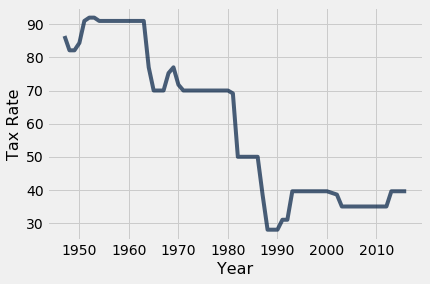

In [69]:
top_tax_joined.plot(0,1)

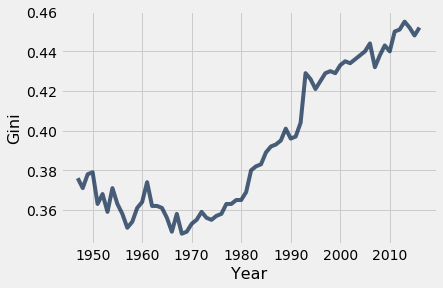

In [70]:
top_tax_joined.plot(0,2)

It appears that over the last 70 years, the top tax rates have decreased significantly from 90% in the 50s to 40% today, while income inequality has grown considerably. This suggests some sort of inverse relationship between the two, so let's create a scatter to see the relationship:

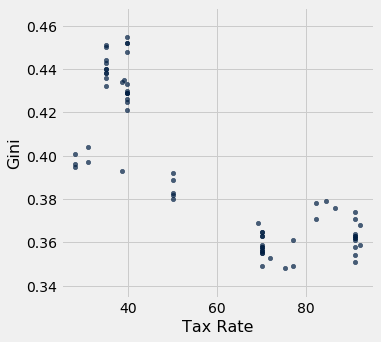

In [71]:
top_tax_joined.scatter(1,2)

Now to find the correlation coefficient r:

In [72]:
def standard_units(array):
    mean = np.mean(array)
    std = np.std(array)
    return (array-mean)/std

In [73]:
standardized_top_tax = Table().with_columns("Year", top_tax_joined.column(0),
                                            "Tax", standard_units(top_tax_joined.column(1)),
                                            "Gini", standard_units(top_tax_joined.column(2)))
standardized_top_tax

Year | Tax     | Gini
1947 | 1.22235 | -0.46511
1948 | 1.02921 | -0.606053
1949 | 1.02921 | -0.408733
1950 | 1.12891 | -0.380545
1951 | 1.42576 | -0.831561
1952 | 1.47047 | -0.690619
1953 | 1.47047 | -0.944315
1954 | 1.42576 | -0.606053
1955 | 1.42576 | -0.831561
1956 | 1.42576 | -0.972504
... (60 rows omitted)

In [74]:
def correlation(tbl):
    return np.mean(tbl.column(0)*tbl.column(1))

In [20]:
r = correlation(standardized_top_tax.drop(0))
r

-0.82755794861840815

There appears to be a strong correlation between the top tax rate and income inequality. However, we have greatly simplified something for our correlation above: our tax rate only takes into account the top tax rate!

Specifically, if our goal was to predict the potentially upcoming Trump tax cuts, we would not get any significant result as the plan will not really change the highest tax rate, but rather the amount of income one earns to qualify into this bracket. (i.e. the top bracket is supposed to go from 400k per year to 1 million per year, while not changing much in tax rate.)

In fact, historically, there were many more brackets than those we have now, which means that the top tax brackets 60-70 years ago only affected a smaller percentage of people. 

Therefore, for the next step, we must consider both tax rate and the income interval for each tax bracket.

## 3. Going 3 dimensional: Using tax brackets

Although our data above appear to have a strong correlation, there is not information for us to make an estimation on the upcoming tax cuts.
Specifically, for the last for the last 25 years, the tax brackets have basically been the same, with the top tax bracket at the 39.6% level. However, the income interval each bracket corresponds to have been shifting almsot annually.
This means that we must consider **both** the income bracket and the tax rate when doing our regression.


### 1. Adjusting for inflation

Our table "non_adjusted" has all the historical data on tax rates and the incomes it corresponded to, but it is not adjusted to inflation. So, our first step is to adjust all values to inflation in 2017 dollars. The equation to convert to 2017 dollars is: 

$\text{Price in 2017 dollars} = \frac{\text{CPI in 2017}}{\text{CPI in original year}} \times \text{Price in original year}$

In [21]:
tax_cpi_join = non_adjusted.join("Year", cpi, "Year")
tax_cpi_join

Year | Tax Rate | Above | CPI
1947 | 20       | 0     | 22.08
1947 | 22       | 2000  | 22.08
1947 | 26       | 4000  | 22.08
1947 | 30       | 6000  | 22.08
1947 | 34       | 8000  | 22.08
1947 | 38       | 10000 | 22.08
1947 | 43       | 12000 | 22.08
1947 | 47       | 14000 | 22.08
1947 | 50       | 16000 | 22.08
1947 | 53       | 18000 | 22.08
... (1057 rows omitted)

In [22]:
current_CPI = cpi.column(1)[-1]
adjusted = tax_cpi_join.column(2) / (tax_cpi_join.column(3)) * current_CPI
adjusted

array([      0.        ,   22082.42753623,   44164.85507246, ...,
        223050.        ,  398350.        ,  450000.        ])

In [23]:
adjusted_tax = tax_cpi_join.drop(2,3).with_columns("Income bracket", adjusted)
adjusted_tax = adjusted_tax.drop(1,2).with_columns("Income bracket", adjusted_tax.column(2), 
                                                   "Tax Rate", adjusted_tax.column(1))
adjusted_tax

Year | Income bracket | Tax Rate
1947 | 0              | 20
1947 | 22082.4        | 22
1947 | 44164.9        | 26
1947 | 66247.3        | 30
1947 | 88329.7        | 34
1947 | 110412         | 38
1947 | 132495         | 43
1947 | 154577         | 47
1947 | 176659         | 50
1947 | 198742         | 53
... (1057 rows omitted)

Let's take a look at this table. When we plot tax rates for each bracket over time:

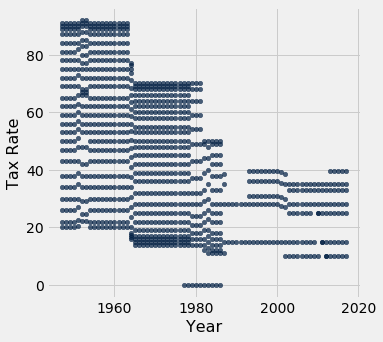

In [24]:
adjusted_tax.scatter(0,2)

We can see that taxes have been decreasing in the last 70 years. 
Notice that there is a big shift in tax rate brackets around 1980; these are the 1st Reagan tax cuts. In addition, the large shift in tax rates around 1964 are the LBJ's tax cuts. Lastly, the more recent Bush's tax cuts can also be seen at around the 2001 mark, where all brackets took a small ~3% drop each.

Now let's take a look at the tax rate to income, adjusted to 2017 dollars:

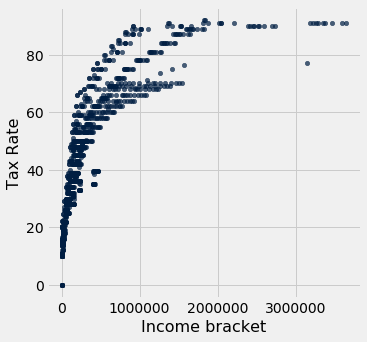

In [25]:
adjusted_tax.scatter(1,2)

At some point in time, the US used to tax up to 90% of income! This tax appeared to only apply to the super-rich that made more than 3.5 million dollars in today's price levels.

### 2. Bringing Income Inequality into the Picture

In [26]:
combined = adjusted_tax.join("Year", gini, "Year")
combined

Year | Income bracket | Tax Rate | Gini
1947 | 0              | 20       | 0.376
1947 | 22082.4        | 22       | 0.376
1947 | 44164.9        | 26       | 0.376
1947 | 66247.3        | 30       | 0.376
1947 | 88329.7        | 34       | 0.376
1947 | 110412         | 38       | 0.376
1947 | 132495         | 43       | 0.376
1947 | 154577         | 47       | 0.376
1947 | 176659         | 50       | 0.376
1947 | 198742         | 53       | 0.376
... (1050 rows omitted)

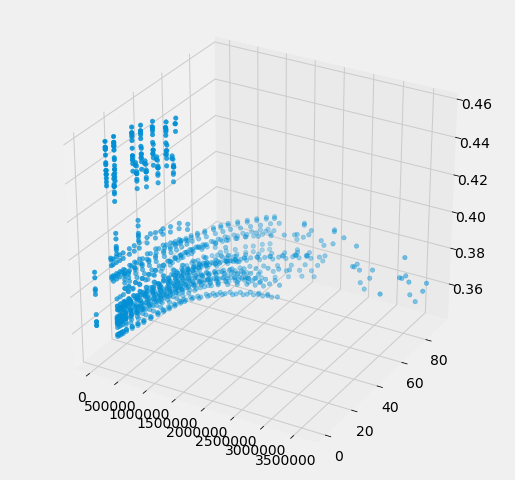

In [27]:
ax = matplotlib.pyplot.figure(figsize=(8,8)).add_subplot(111, projection='3d')
ax.scatter(combined.column(1), 
           combined.column(2), 
           combined.column(3));

Let's visualize our brackets and tax rates. I will categorically divide up our tax data by time into 3 periods. The 3 periods I have chosen are:

Red: **Pre-LBJ era (Before 1965)** signified by very high tax rates and many brackets.

Green: **Pre-Reagan era (Before 1982)** categorized by considerably lower tax rates by around 20% than before across the board, but still with many tax brackets.

Blue: **Reagan-Bush era** even lower tax rates and also greatly reduced the amount of tax brackets.
    
These differences in tax rates in each period can be seen in the graph directly below, which plots all tax rates with respect to time.

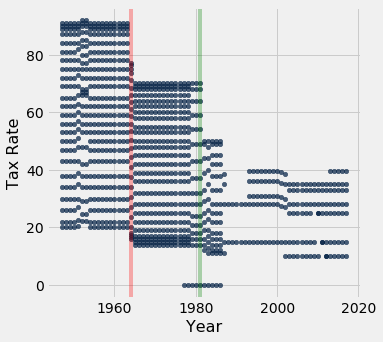

In [28]:
adjusted_tax.scatter(0,2)
plots.axvline(x=1964, alpha = 0.3, c = "red")
plots.axvline(x=1981, alpha = 0.3, c = "green")

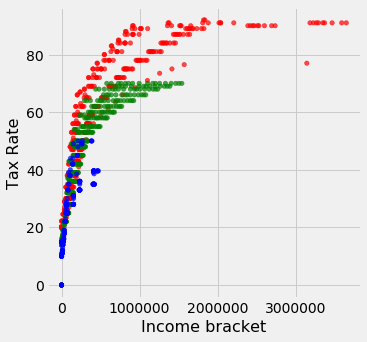

In [29]:
color = make_array()
for i in range(combined.num_rows):
    if combined.row(i)[0] <= 1964:
        color = np.append(color, "red")
    elif combined.row(i)[0] <= 1981:
        color = np.append(color, "green")
    else:
        color = np.append(color, "blue")
combined_colors = combined.with_columns("Color", color)
combined_colors.scatter(1,2, color = combined_colors.column(4))

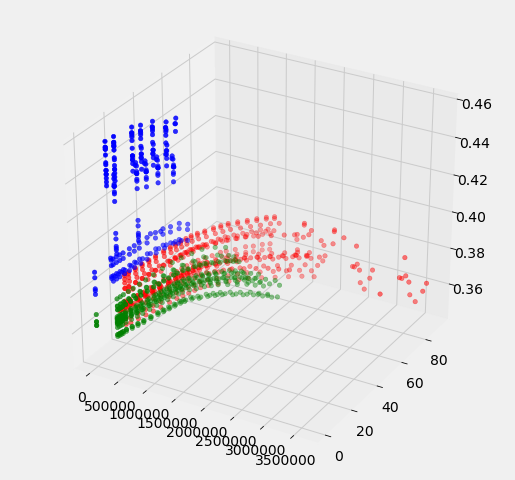

In [30]:
ax = matplotlib.pyplot.figure(figsize=(8,8)).add_subplot(111, projection='3d')
ax.scatter(combined_colors.column(1), 
           combined_colors.column(2), 
           combined_colors.column(3), c = combined_colors.column(4));

The effects are clearly visible: from the blue dots, having less tax brackets at lower tax rates and lower income levels increase income inequality.

### 3. Aggregating each year into 1 point

Unfortunately, there are too many tax rate + income points for us to conduct any meaningful regression from the above scatter. Therefore, we must aggregate each year's tax rates and brackets into 1 (x,y) value.

I have simply chosen to take the arithmetic average of the income and tax rate for each year. An improvement could be to take the geometric average for the tax income, as generally the tax brackets scale exponentially, but there are a couple complicating problems with this that are hard to resolve.

In [31]:
aggregated = combined.group(0, np.average)
aggregated

Year | Income bracket average | Tax Rate average | Gini average
1947 | 493174                 | 59.2083          | 0.376
1948 | 450902                 | 59.2083          | 0.371
1949 | 455238                 | 59.2083          | 0.378
1950 | 456000                 | 59.2083          | 0.379
1951 | 419949                 | 59.7417          | 0.363
1952 | 410452                 | 62.575           | 0.368
1953 | 406772                 | 62.575           | 0.359
1954 | 404205                 | 59.2083          | 0.371
1955 | 815372                 | 59.2083          | 0.363
1956 | 802157                 | 59.2083          | 0.358
... (60 rows omitted)

Plotting this...

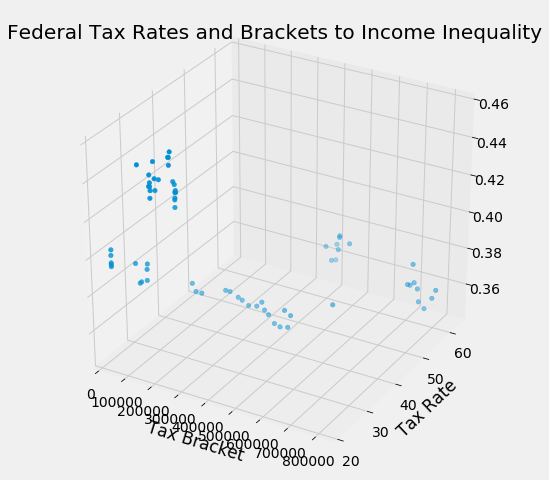

In [75]:
ax = matplotlib.pyplot.figure(figsize=(8,8)).add_subplot(111, projection='3d')
ax.scatter(aggregated.column(1), 
           aggregated.column(2), 
           aggregated.column(3));
plots.title("Federal Tax Rates and Brackets to Income Inequality")
plots.xlabel("Tax Bracket")
plots.ylabel("Tax Rate")

In [33]:
def find_aggregated_min(slope1, slope2, intercept):
    residual_sum = 0
    for i in range(aggregated.num_rows):
        x = aggregated.column(1)[i]
        y = aggregated.column(2)[i]
        predicted = x*slope1 + y*slope2 + intercept
        residual = (aggregated.column(3)[i]-predicted) ** 2
        residual_sum += residual
    return residual_sum
a = minimize(find_aggregated_min)
agg_s1 = a[0]
agg_s2 = a[1]
agg_intercept = a[2]
agg_s1, agg_s2, agg_intercept

(4.6151120012371352e-08, -0.0024928577908792365, 0.47439075976966177)

In [34]:
def predict_agg(x, y):
    return agg_s1*x + agg_s2*y + agg_intercept

Let's test this out on our 2016 data:

In [35]:
x_2016 = aggregated.where(0, 2016).column(1).item(0)
y_2016 = aggregated.where(0, 2016).column(2).item(0)
predicted_2016 = predict_agg(x_2016, y_2016)
aggregated.where(0, 2016).column(3).item(0), predicted_2016

(0.452, 0.41706104047886483)

One more for 1990's data:

In [36]:
x_1990 = aggregated.where(0, 1990).column(1).item(0)
y_1990 = aggregated.where(0, 1990).column(2).item(0)
predicted_1990 = predict_agg(x_1990, y_1990)
actual_1990 = aggregated.where(0, 1990).column(3).item(0)
actual_1990, predicted_1990

(0.396, 0.42219963228202695)

Our regresiion plane does not seem to be a very good predictor. It underpredicts 2016's income inequality and over predicts 1990's income inequality by a considerable amount. This is because fluctuations have been very large and 'averages' out the slope of the regression plane. Let's take a look at the residual RMS, which we will later use to compare to our improved model: 

In [37]:
def residuals(table, s1, s2, intercept):
    residual_sum = 0
    for i in range(table.num_rows):
        predicted = table.column(1)[i]*s1 + table.column(2)[i]*s2 + intercept
        residual_sum += (table.column(3)[i] - predicted) ** 2
    return (residual_sum / table.num_rows) ** 0.5
residuals(aggregated, agg_s1, agg_s2, agg_intercept)

0.023897082335873669

### 4. Null hypotheses tests

For the null hypothesis test we will test for the true slope on both dimensions and hence essentially do 2 hypothesis tests. The null hypotheses will be that the slope is 0 between either independent variable and the dependent variable, i.e. there is no correlational relationship between either independent variable with the dependent variable. On the other hand, the alternative hypothesis is that there is some correlation and hence slope between the 2 independent variables and the dependent variable.

Null hypothesis 1: there is no relationship between average incomes for the brackets and income inequality. The slope exists simply due to chance.

Null hypothesis 2: there is no relationship between the average tax rate and income inequality. The slope exists simply due to chance.


Let's first take a look at how these independent variables separately correlate with the dependent variable.

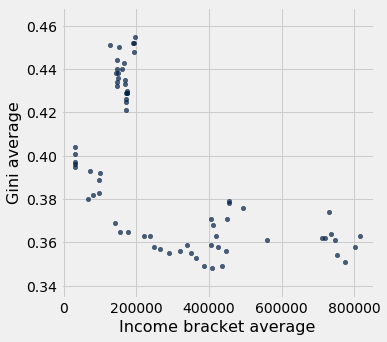

In [38]:
aggregated.scatter(1,3)

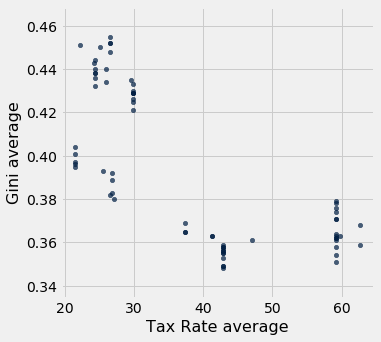

In [39]:
aggregated.scatter(2,3)

Now we can begin our 2 null hypotheses tests.

In [40]:
def slope(table):
    def least_squares_estimate(X, b):
        # X - matrix
        # b - array
        return np.linalg.inv(X.T * X) * (X.T * np.matrix(b).T)
    tax_rate = table.column(1)
    tax_income = table.column(2)
    X = np.matrix([tax_rate, tax_income, [1 for _ in range(len(tax_rate))]]).T
    a = least_squares_estimate(X, table.column(3))
    return float(a[0]), float(a[1]), float(a[2])

In [41]:
s1 = make_array()
s2 = make_array()
intercept = make_array()
for i in range(5000):
    table = aggregated.sample()
    result = slope(table)
    s1 = np.append(s1, result[0])
    s2 = np.append(s2, result[1])
    intercept = np.append(intercept, result[2])
slopes = Table().with_columns("Slope1", s1, "Slope2", s2, "Intercept", intercept)
slopes

Slope1      | Slope2      | Intercept
3.99716e-08 | -0.00228914 | 0.4659
4.29342e-08 | -0.00244149 | 0.477644
3.92586e-08 | -0.00241779 | 0.471554
5.87178e-08 | -0.0029116  | 0.484054
1.07134e-07 | -0.00350087 | 0.492463
3.90467e-09 | -0.00167621 | 0.456653
2.2801e-08  | -0.00198554 | 0.457204
3.28872e-08 | -0.00249038 | 0.4833
1.28456e-07 | -0.00412054 | 0.50869
7.52476e-08 | -0.00309411 | 0.485968
... (4990 rows omitted)

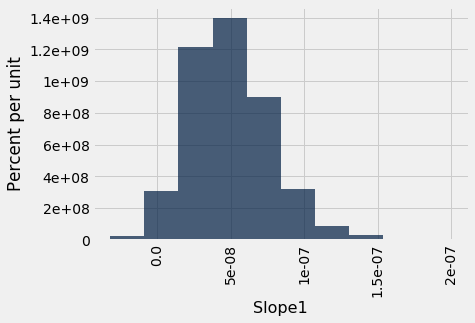

In [42]:
slopes.hist(0)

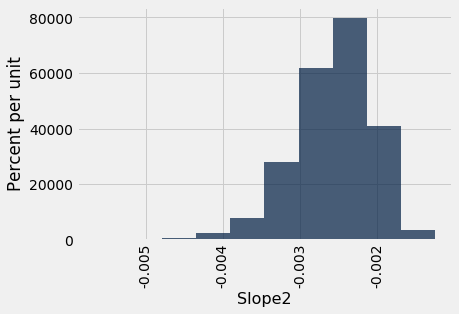

In [43]:
slopes.hist(1)

In [77]:
p_val_slope1 = slopes.where(0, are.below(0)).num_rows/slopes.num_rows
p_val_slope2 = slopes.where(1, are.above(0)).num_rows/slopes.num_rows
print("p value for null hypothesis 1: ", p_val_slope1, "\np value for null hypothesis 2: ", p_val_slope2)

p value for null hypothesis 1:  0.0172 
p value for null hypothesis 2:  0.0


Hence, we can conclude that both variables have some association with income inequality.

### 5. Only considering data since 1993

We shall use only tax rate data since the Reagan era from 1982 onwards. This data is the most representative of today and should hence predict the effects of Trump's tax cuts well.

In [45]:
recent = aggregated.where(0, are.above(1981))
recent

Year | Income bracket average | Tax Rate average | Gini average
1982 | 66834.4                | 27.0769          | 0.38
1983 | 79727.5                | 26.5             | 0.382
1984 | 96779.4                | 26.8667          | 0.383
1985 | 97163.7                | 26.8667          | 0.389
1986 | 98995.7                | 26.8667          | 0.392
1987 | 71311.3                | 25.5             | 0.393
1988 | 30732                  | 21.5             | 0.395
1989 | 30400.1                | 21.5             | 0.401
1990 | 30450.3                | 21.5             | 0.396
1991 | 30473.8                | 21.5             | 0.397
... (25 rows omitted)

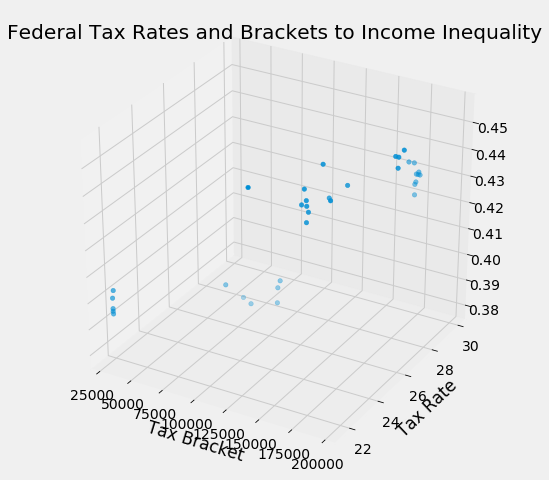

In [78]:
recent_ax = matplotlib.pyplot.figure(figsize=(8,8)).add_subplot(111, projection='3d')
recent_ax.scatter(recent.column(1), 
           recent.column(2), 
           recent.column(3));
plots.title("Federal Tax Rates and Brackets to Income Inequality")
plots.xlabel("Tax Bracket")
plots.ylabel("Tax Rate")

In [47]:
def find_recent_min(slope1, slope2, intercept):
    residual_sum = 0
    for i in range(recent.num_rows):
        x = recent.column(1)[i]
        y = recent.column(2)[i]
        predicted = x*slope1 + y*slope2 + intercept
        residual = (recent.column(3)[i]-predicted) ** 2
        residual_sum += residual
    return residual_sum
a = minimize(find_recent_min)
recent_s1 = a[0]
recent_s2 = a[1]
recent_intercept = a[2]
recent_s1, recent_s2, recent_intercept

(5.4506369916172899e-07, -0.0055138129116306797, 0.49527073035552105)

In [48]:
def least_squares_estimate(X, b):
    # X - matrix
    # b - array
    return np.linalg.inv(X.T * X) * (X.T * np.matrix(b).T)

In [49]:
tax_rate = recent.column(1)
tax_income = recent.column(2)

X = np.matrix([tax_rate, tax_income, [1 for _ in range(len(tax_rate))]]).T
X

matrix([[  6.68344195e+04,   2.70769231e+01,   1.00000000e+00],
        [  7.97275287e+04,   2.65000000e+01,   1.00000000e+00],
        [  9.67793796e+04,   2.68666667e+01,   1.00000000e+00],
        [  9.71637329e+04,   2.68666667e+01,   1.00000000e+00],
        [  9.89956761e+04,   2.68666667e+01,   1.00000000e+00],
        [  7.13112599e+04,   2.55000000e+01,   1.00000000e+00],
        [  3.07320021e+04,   2.15000000e+01,   1.00000000e+00],
        [  3.04000826e+04,   2.15000000e+01,   1.00000000e+00],
        [  3.04502906e+04,   2.15000000e+01,   1.00000000e+00],
        [  3.04737500e+04,   2.15000000e+01,   1.00000000e+00],
        [  3.11480443e+04,   2.15000000e+01,   1.00000000e+00],
        [  1.74369826e+05,   2.99200000e+01,   1.00000000e+00],
        [  1.71378271e+05,   2.99200000e+01,   1.00000000e+00],
        [  1.70637003e+05,   2.99200000e+01,   1.00000000e+00],
        [  1.70653000e+05,   2.99200000e+01,   1.00000000e+00],
        [  1.71535635e+05,   2.99200000e

In [50]:
a = least_squares_estimate(X, recent.column(3))
a

matrix([[  5.45063699e-07],
        [ -5.51381291e-03],
        [  4.95270730e-01]])

Let's visualize the regression plane!

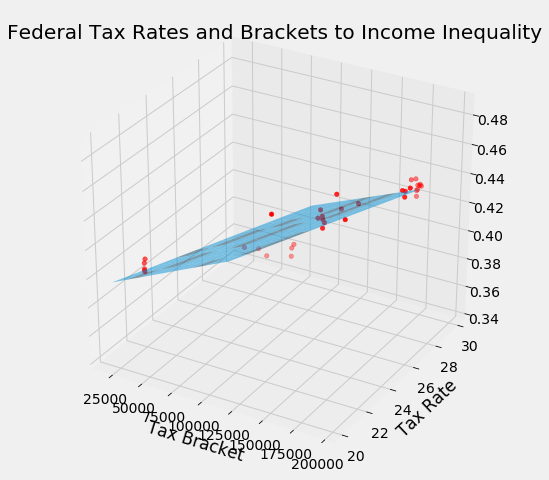

In [51]:
x=np.arange(20000, 200000, 180000/10)
y=np.arange(20, 30)
X, Y = np.meshgrid(x,y)

Z = X*recent_s1 + Y*recent_s2 + recent_intercept
recent_ax = matplotlib.pyplot.figure(figsize=(8,8)).add_subplot(111, projection='3d')
recent_ax.plot_surface(X, Y, Z, alpha=0.5)
recent_ax.scatter(recent.column(1), 
           recent.column(2), 
           recent.column(3), c= "RED")
plots.title("Federal Tax Rates and Brackets to Income Inequality")
plots.xlabel("Tax Bracket")
plots.ylabel("Tax Rate")

And our residual appears to be much smaller:

In [52]:
residuals(recent, recent_s1, recent_s2, recent_intercept)

0.0067906714590683067

Lastly, just to make sure, let's take a look at 2016's data to see how well our predictor is:

In [53]:
x_2016 = recent.where(0, 2016).column(1).item(0)
y_2016 = recent.where(0, 2016).column(2).item(0)

def predict(x, y):
    return recent_s1 * x + recent_s2 * y + recent_intercept
predicted_2016 = predict(x_2016, y_2016)
actual_2016 = recent.where(0, 2016).column(3).item(0)
actual_2016, predicted_2016

(0.452, 0.4526133576476879)

That's pretty good. Now we can confidently move on to the final icing on the cake.

### 6. Predicting Trump's Tax Cuts (on Federal Income Tax) on Income Inequality

In [54]:
#IGNORE THIS CELL: Old trump tax proposal 
trump = Table().with_columns("Lower", make_array(0, 90000, 260000, 1000000), 
                               "Tax", make_array(12, 25, 35, 39.6))
trump

Lower   | Tax
0       | 12
90000   | 25
260000  | 35
1000000 | 39.6

In [55]:
#New Trump tax proposal from http://www.businessinsider.com/senate-tax-plan-brackets-trump-tax-reform-two-charts-2017-11
trump = Table().with_columns("New Bracket", make_array(0,19050,77400,140000,320000,400000,1000000),
                            "New Tax", make_array(10,12,22,24,32,35,38.5))
trump.with_columns("2016 Bracket", combined.where(0, 2016).column(1),
                  "2016 Tax", combined.where(0, 2016).column(2))

New Bracket | New Tax | 2016 Bracket | 2016 Tax
0           | 10      | 0            | 10
19050       | 12      | 18143.8      | 15
77400       | 22      | 73693.4      | 25
140000      | 24      | 148810       | 28
320000      | 32      | 226722       | 33
400000      | 35      | 404907       | 35
1000000     | 38.5    | 457407       | 39.6

Just from looking at this table, we can see that for slightly lower tax rates per bracket, it looks like the new tax cuts will move the brackets upwards to considerably higher income levels. 

Notably, take a look at the highest bracket: now only households earning above 1 million will be taxed at 38.5%, while before households earning less than half that would be taxed at a slightly higher rate.

Anyways...let's see what the tax cut will do on income inequality:

In [56]:
trump_x = np.average(trump.column(0))
trump_y = np.average(trump.column(1))
predicted_gini = predict(trump_x,trump_y)
predicted_gini

0.51094834950652701

It looks like Trump's tax cuts will greatly increase our gini coefficient. Let's take a look again at our recent gini trends since 1993:

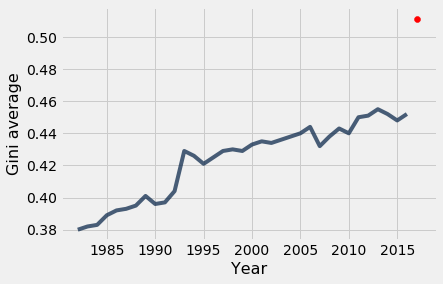

In [57]:
recent.plot(0, 3)
plots.scatter(2017, predicted_gini, c="Red")

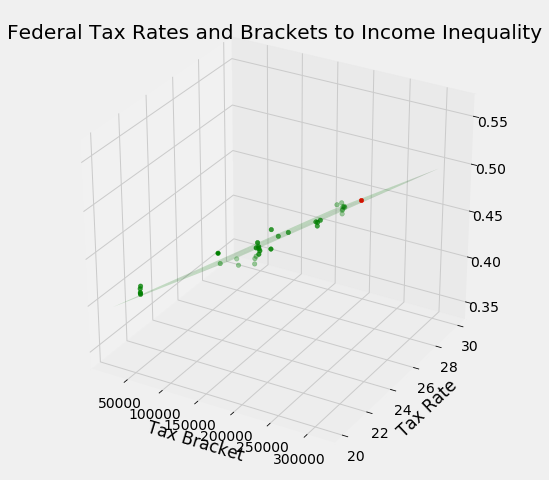

In [58]:
x=np.arange(20000, 350000, 330000/10)
y=np.arange(20, 30)
X, Y = np.meshgrid(x,y)

Z = X*recent_s1 + Y*recent_s2 + recent_intercept
recent_ax = matplotlib.pyplot.figure(figsize=(8,8)).add_subplot(111, projection='3d')
recent_ax.plot_surface(X, Y, Z, alpha=0.2, color = "green")
recent_ax.scatter(recent.column(1), 
           recent.column(2), 
           recent.column(3), c= "green")
recent_ax.scatter(trump_x, trump_y, predicted_gini, c="red")
plots.title("Federal Tax Rates and Brackets to Income Inequality")
plots.xlabel("Tax Bracket")
plots.ylabel("Tax Rate")

0.51 would be a great increase in income inequality!

[With context](https://en.wikipedia.org/wiki/List_of_countries_by_income_equality), a gini coefficient of 0.5 is a very high gini index compared to the rest of the world. This would put us over countries such as Saudi Arabia, Venezuela, Mexico, Brazil, China, and more. According to World Bank's index, the US would go from around 50th in income inequality to above the top 20. 

## Submission

In [79]:
_ = ok.submit()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'exploration.ipynb'.
Submit... 100% complete
Submission successful for user: alanliang@berkeley.edu
URL: https://okpy.org/cal/data8/fa17/exploration/submissions/3l90ZQ



# Bibliography and Sources of Data

https://www.thebalance.com/trump-s-tax-plan-how-it-affects-you-4113968 

https://fred.stlouisfed.org/series/CPIAUCSL

http://www.taxpolicycenter.org/statistics/historical-highest-marginal-income-tax-rates

https://files.taxfoundation.org/legacy/docs/fed_individual_rate_history_nominal.pdf

https://fred.stlouisfed.org/series/GINIALLRF

http://www.taxpolicycenter.org/statistics/historical-highest-marginal-income-tax-rates

http://www.businessinsider.com/senate-tax-plan-brackets-trump-tax-reform-two-charts-2017-11